In [1]:
from train import DataGenerator, PatientDataGenerator
import numpy as np
from keras.models import load_model
import shap
import matplotlib.pyplot as plt
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

Using TensorFlow backend.


In [10]:
def load_data():
    g = DataGenerator()
    X, y = g.data()
    train_set, valid_set, test_set = g.split(X, y)
    
    # do normalize using means and stds from training data
    train_set[0], means_and_stds = DataGenerator.normalize(train_set[0])
    valid_set[0], _ = DataGenerator.normalize(valid_set[0], means_and_stds)
    test_set[0], _ = DataGenerator.normalize(test_set[0], means_and_stds)
    
    return train_set, valid_set, test_set

WHOLE_DATASET = load_data()
print(len(WHOLE_DATASET[0][1]), len(WHOLE_DATASET[1][1]), len(WHOLE_DATASET[2][1]))

44 19 27


In [8]:
def load_patient_data():
    g = PatientDataGenerator()
    X, y = g.data()
    train_set, valid_set, test_set = g.split(X, y)
    
    # do normalize using means and stds from training data
    train_set[0], means_and_stds = DataGenerator.normalize(train_set[0])
    valid_set[0], _ = DataGenerator.normalize(valid_set[0], means_and_stds)
    test_set[0], _ = DataGenerator.normalize(test_set[0], means_and_stds)
    
    return train_set, valid_set, test_set

WHOLE_DATASET_P = load_patient_data()

In [3]:
model_path = '/home/scsu/unet-master/my_unet/model_checkpoints/20190402224806/2000-0.75.h5'
model = load_model(model_path, compile=False)
#model.summary()

In [4]:
def plot(data, pred):
    
    t = np.arange(0.0, 10000.0, 1.0)
    #fig, ax1 = plt.subplots()
    n_channel = 6
    fig, axes = plt.subplots(n_channel, 1, figsize=(30, 3*n_channel), sharex=True)
    
    for i_channel, ax1 in enumerate(axes):
        color = 'tab:red'
        ax1.set_xlabel('time')
        ax1.set_ylabel('ecg', color=color)
        ax1.plot(t, data[i_channel], color=color, alpha=0.3)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('prab.', color=color)  # we already handled the x-label with ax1
        ax2.plot(t, np.convolve(pred[i_channel], np.ones((5,))/5, 'same'), color=color)
        ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

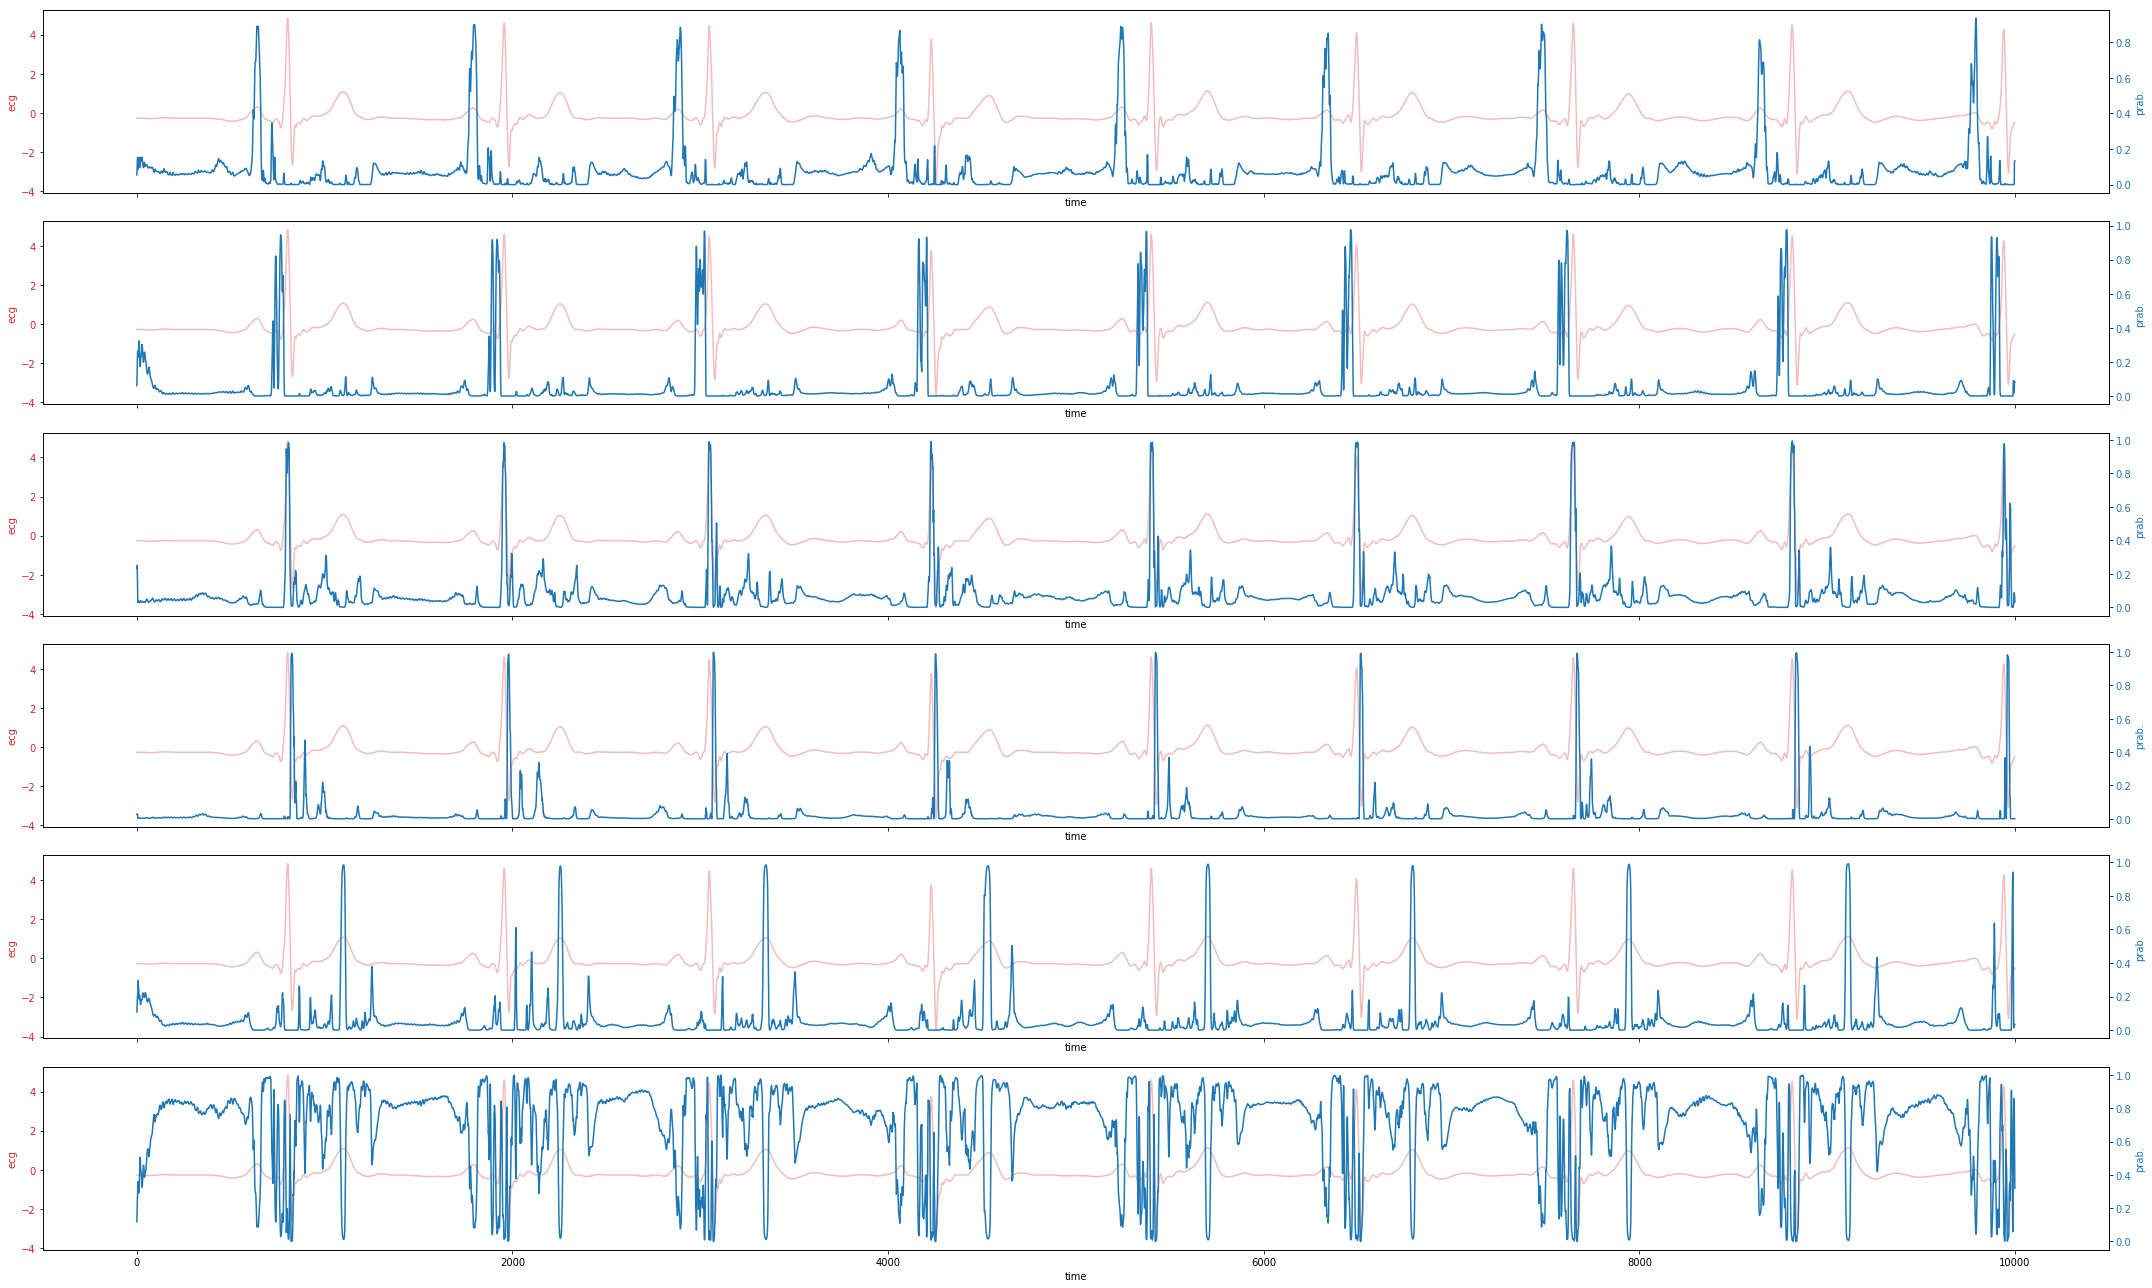

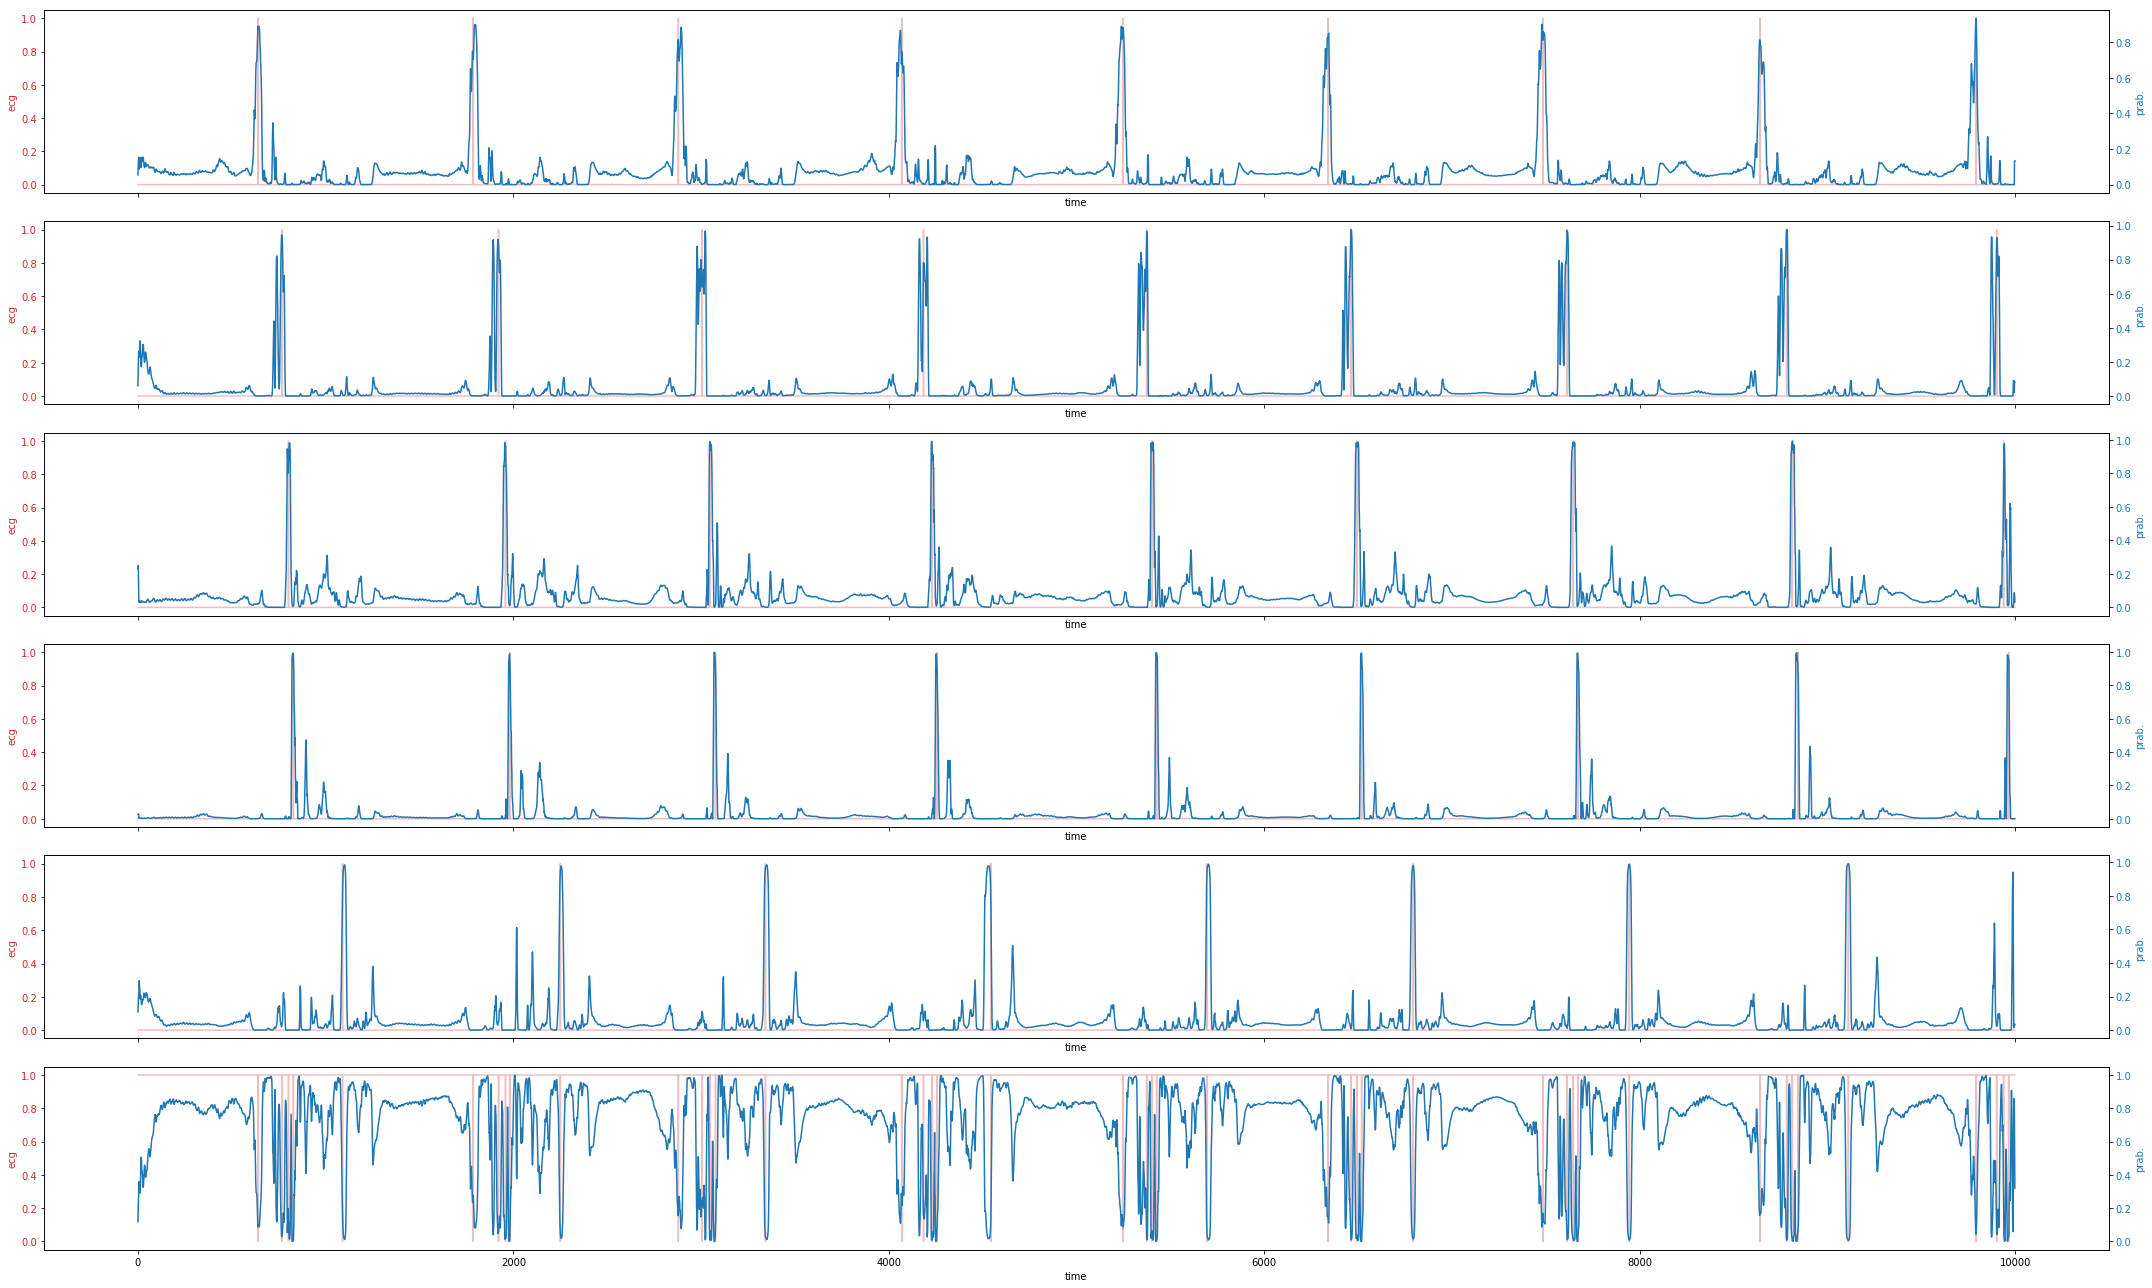

In [33]:
data_index = 10
#blue:probability of correspond channel label; red:ecg
plot(np.repeat((np.swapaxes(WHOLE_DATASET[2][0][:], 1, 2)[data_index][0])[np.newaxis, ...], 6 , 0), 
     np.swapaxes(model.predict(WHOLE_DATASET[2][0][:]), 1, 2)[data_index])
#blue:probability of correspond channel label; red:channel ecg label
plot(np.swapaxes(WHOLE_DATASET[2][1][:], 1, 2)[data_index], np.swapaxes(model.predict(WHOLE_DATASET[2][0][:]), 1, 2)[data_index])


In [20]:
def ecg_seg(data, pred):
    diff = []
    peak = []
    for x in range(5): #represent p,q,r,s,t
        diff.append(np.diff(pred[x]))
        peak.append(np.zeros(10000))

    for index in range(10000-2):
        for x in range(5): #p,q,r,s,t
            if diff[x][index]>=0 and diff[x][index+1]<=0: #peak
                if pred[x][index+1]>np.mean(pred[x])+(3*np.std(pred[x])): #threshold
                    if pred[x][index+1]==np.max(pred[x][max(0, index-300):min(9999, index+300)]): #threshold    
                        peak[x][index+1] = 1
    
    ind = []
    for x in range(5):
        ind.append(np.where(peak[x]==1)[0])
    print(len(ind[2]), ind[2], type(ind[2])) #r's info
    
    seg = np.zeros(10000)
   
    if ind[0][0]>ind[4][0]: #T start
        for i in range(len(ind[0])):
            position = (ind[0][i] + ind[4][i])//2   
            seg[position] = 1
    else: #P start
        for i in range(len(ind[0])-1):
            position = (ind[0][i+1] + ind[4][i])//2
            seg[position] = 1
            
    t = np.arange(0.0, 10000.0, 1.0)
    n_channel = 1
    fig, ax1 = plt.subplots(n_channel, 1, figsize=(30, 5*n_channel), sharex=True)
    
    
    color = 'tab:red'
    ax1.set_xlabel('time')
    ax1.set_ylabel('ecg', color=color)
    ax1.plot(t, data[0], color=color)
    
    c = ['g', 'm', 'y', 'k', 'c']
    l = ['p', 'q', 'r', 's', 't']
    for x in range(5):
        ax1.plot(ind[x], data[0][ind[x]], 'o', color=c[x], label=l[x])

    
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend()
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('seg.', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, seg, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
        

9 [1104 2254 3423 4574 5710 6895 7209 8079 9264] <class 'numpy.ndarray'>


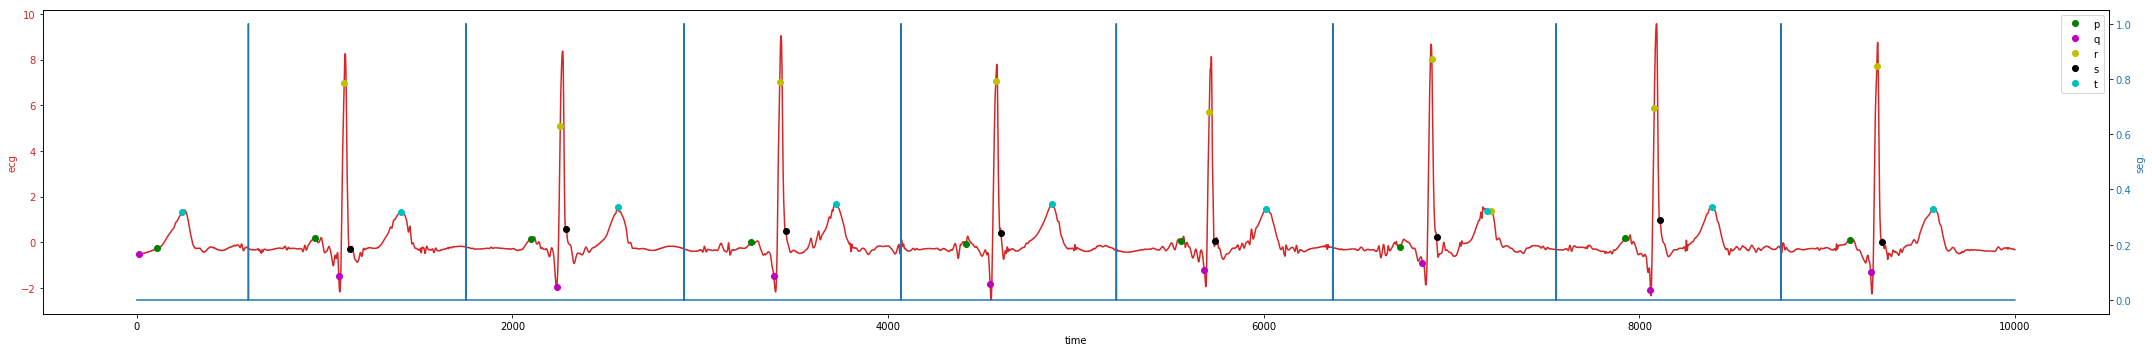

In [30]:
data_index = 9
ecg_seg(np.repeat((np.swapaxes(WHOLE_DATASET[2][0][:], 1, 2)[data_index][0])[np.newaxis, ...], 6 , 0),
        np.swapaxes(model.predict(WHOLE_DATASET[2][0][:]), 1, 2)[data_index])
#normal

14 [ 413 1123 1841 2559 3275 4003 4725 5449 6169 6885 7593 8299 9015 9729] <class 'numpy.ndarray'>


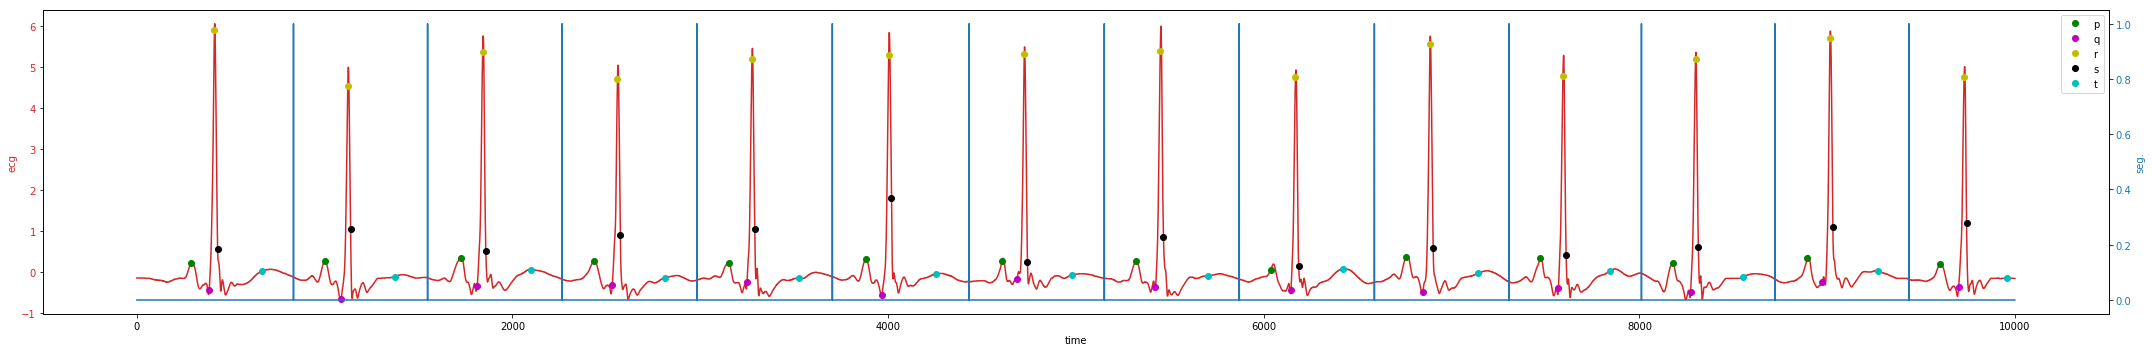

In [32]:
data_index = 15
ecg_seg(np.repeat((np.swapaxes(WHOLE_DATASET_P[0][0][:], 1, 2)[data_index][0])[np.newaxis, ...], 6 , 0),
        np.swapaxes(model.predict(WHOLE_DATASET_P[0][0][:]), 1, 2)[data_index])
#patient